In [77]:
import pandas as pd
import numpy as np
import re
import string
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import cross_validation
%matplotlib inline
import gensim
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.ldamodel import LdaModel

In [83]:
master = pd.read_csv('data/master.csv')

In [84]:
dups = master.duplicated('Comment')
data = master[-dups]

In [86]:
print len(data)
data2 = data[pd.notnull(data['State'])]
data2['Count'] = 1
data2 = data2[['State', 'Recommendations', 'EditorPick', 'Count']]
by_state = data2.groupby('State').sum()
by_state

88191


/Users/datascientist/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Recommendations,EditorPick,Count
State,,,
AK,1493,3,98
AL,2083,5,141
AR,1946,3,97
AZ,15749,20,708
CA,96473,170,4820
CO,17465,27,869
CT,24026,63,1205
DC,10402,38,767
DE,1406,2,117


In [87]:
by_state.to_csv('data/by_state.csv')

In [29]:
hilary = pd.read_csv('data/hilary_sim_scores.csv', header=None)
sanders = pd.read_csv('data/sanders_sim_scores.csv', header=None)
biden = pd.read_csv('data/biden_sim_scores.csv', header=None)
trump = pd.read_csv('data/trump_sim_scores.csv', header=None)
bush = pd.read_csv('data/bush_sim_scores.csv', header=None)
carson = pd.read_csv('data/carson_sim_scores.csv', header=None)

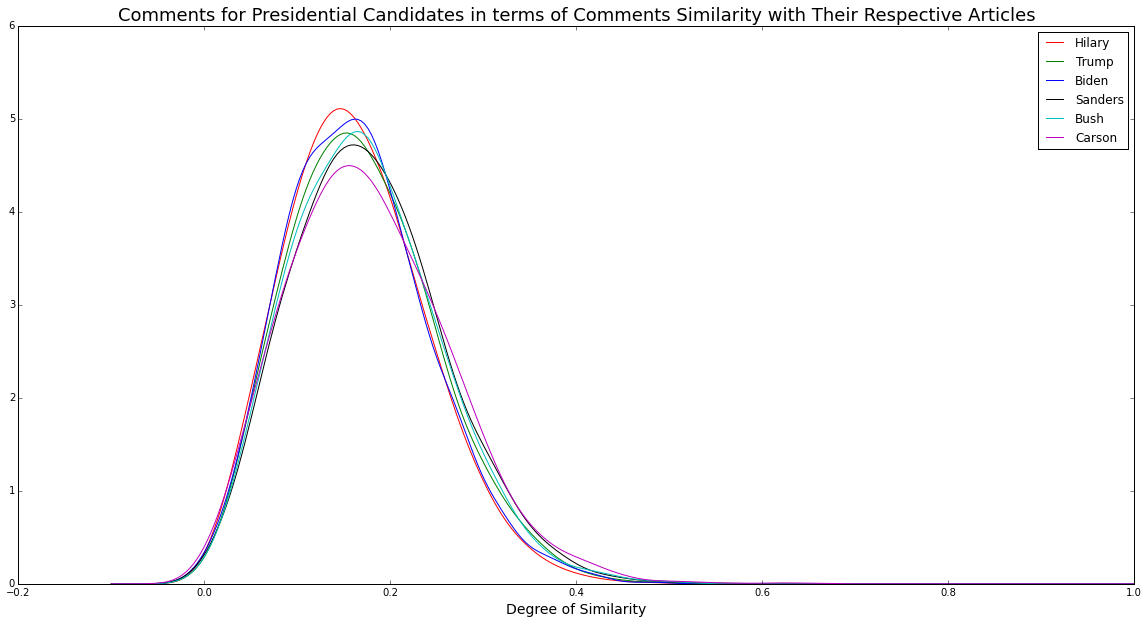

In [30]:
from scipy.stats import gaussian_kde
plt.figure(figsize=(20,10))

metric = 1

data = hilary[metric]
density = gaussian_kde(data)
xs = np.linspace(-0.1,1,300)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs), 'r', label = 'Hilary')

data = trump[metric]
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs), 'g', label = 'Trump')

data = biden[metric]
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs), 'b', label = 'Biden')

data = sanders[metric]
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs), 'black', label = 'Sanders')

data = bush[metric]
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs), 'c', label = 'Bush')

data = carson[metric]
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs), 'm', label = 'Carson')
plt.xlabel('Degree of Similarity', fontsize=14)
plt.title('Comments for Presidential Candidates in terms of Comments Similarity with Their Respective Articles', fontsize=18)

# plt.xlim(0.3, 0.5)
# plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
def word_count(text):
    out = text.translate(string.maketrans("",""), string.punctuation)
    return len(out.split())

In [ ]:
data['word_count'] = data['Comment'].apply(lambda x: word_count(str(x)))

In [ ]:
data['Recommendations'] = data['Recommendations'].apply(lambda x: 0 if x == np.nan else x)
x = data['Recommendations'].values
np.percentile(x, 95)


In [ ]:
data['Rec'] = data['Recommendations'].apply(lambda x: 1 if x > 79 else 0)
data['Rec'].value_counts()

In [ ]:
data['Candidate'].value_counts()

In [ ]:
cols_encode = ['State', 'Candidate']
encoders = {}
for col in cols_encode:
    le = preprocessing.LabelEncoder()
    le.fit(data[col])
    encoders[col] = le
    data[col] = le.transform(data[col])


In [ ]:
reg = data[['EditorPick', 'Sentiment', 'Subjectivity', 'word_count', 'Rec', 'State', 'Candidate']]

In [ ]:
# recs = data['Rec'].values
# recs = np.nan_to_num(recs)
# plt.hist(recs, bins=300)


In [ ]:
X = reg.drop('Rec', axis = 1).values
X = np.nan_to_num(X)
y = reg['Rec'].values

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
y_pred = rf.fit(X_train, y_train).predict(X_test)

print 'Recall: %f'%(metrics.recall_score(y_test, y_pred))
print 'Precision: %f'%(metrics.precision_score(y_test, y_pred))

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

svc_linear = SVC()
y_pred = svc_linear.fit(X_train, y_train).predict(X_test)

print 'Recall: %f'%(metrics.recall_score(y_test, y_pred))
print 'Precision: %f'%(metrics.precision_score(y_test, y_pred))

In [ ]:
commentOnly = data[['Comment', 'Rec']]

In [ ]:
X = commentOnly['Comment']
y = commentOnly['Rec'].values
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [ ]:
#type(commentOnly.loc[0,'Comment'])

In [ ]:
vectorizer = TfidfVectorizer(stop_words = 'english')

vectorized_X_train  = vectorizer.fit_transform(X_train)
vectorized_X_test = vectorizer.transform(X_test)

In [ ]:
print vectorized_X_train.shape
print y_train.shape

In [ ]:
X = reg.drop('Candidate', axis = 1).values
X = np.nan_to_num(X)
y = reg['Candidate'].values

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [ ]:
weights = dict()
for i in range(6):
    weights[i] = x[i]/float(x.sum())

In [ ]:
weights

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
base_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight = weights)
ovr = OneVsRestClassifier(estimator=base_clf, n_jobs=-1)
y_pred = ovr.fit(X_train, y_train).predict(X_test)

print 'Accuracy: %f'%(metrics.accuracy_score(y_test, y_pred))
print 'Recall: %f'%(metrics.recall_score(y_test, y_pred))
print 'Precision: %f'%(metrics.precision_score(y_test, y_pred))

In [ ]:
x = reg['Candidate'].value_counts()

In [ ]:
data_drop = data.drop_duplicates('Comment')
len(data_drop)

In [27]:
sanders = pd.read_csv('data/sanders_scores.csv')

In [ ]:
stoplist = set('for a of the and to in'.split())
texts = [[word for word in comment.lower().split() if word not in stoplist]
        for comment in content]

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
          for text in texts]

In [ ]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
model = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=5)
model.print_topics(5)